In [1]:
!pip install -U scikit-learn imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 55.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 8.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.7.2 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.

In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from tensorflow.keras import Sequential, layers, Input

import shap
import lime
from lime.lime_tabular import LimeTabularExplainer



# Dataset

In [3]:
hotels = pd.read_csv('/kaggle/input/international-hotel-booking-analytics/hotels.csv')
reviews = pd.read_csv('/kaggle/input/international-hotel-booking-analytics/reviews.csv')
users = pd.read_csv('/kaggle/input/international-hotel-booking-analytics/users.csv')

print("hotels:", hotels.shape)
print("reviews:", reviews.shape)
print("users:", users.shape)

hotels: (25, 13)
reviews: (50000, 12)
users: (2000, 6)


In [4]:
def normalize_col(df, col):
    if col in df.columns and df[col].dtype == object:
        df[col] = df[col].astype(str).str.strip()
        return True
    return False

for c in ['country', 'user_gender', 'traveller_type', 'city', 'hotel_name']:
    if c in hotels.columns:
        normalize_col(hotels, c)
    if c in users.columns:
        normalize_col(users, c)
    if c in reviews.columns:
        normalize_col(reviews, c)

In [5]:
df = reviews.merge(hotels, on='hotel_id', how='left', suffixes=('', '_hotel'))
df = df.merge(users, on='user_id', how='left', suffixes=('', '_user'))

print("\nMerged dataset shape:", df.shape)
print("\nMerged columns (first 40):\n", df.columns.tolist()[:40])

df.head()


Merged dataset shape: (50000, 29)

Merged columns (first 40):
 ['review_id', 'user_id', 'hotel_id', 'review_date', 'score_overall', 'score_cleanliness', 'score_comfort', 'score_facilities', 'score_location', 'score_staff', 'score_value_for_money', 'review_text', 'hotel_name', 'city', 'country', 'star_rating', 'lat', 'lon', 'cleanliness_base', 'comfort_base', 'facilities_base', 'location_base', 'staff_base', 'value_for_money_base', 'user_gender', 'country_user', 'age_group', 'traveller_type', 'join_date']


,review_id,user_id,hotel_id,review_date,score_overall,score_cleanliness,score_comfort,score_facilities,score_location,score_staff,...,comfort_base,facilities_base,location_base,staff_base,value_for_money_base,user_gender,country_user,age_group,traveller_type,join_date
0,1,1600,1,2022-10-07,8.7,8.6,8.7,8.5,9.0,8.8,...,8.8,8.9,9.5,8.6,8.0,Female,New Zealand,25-34,Solo,2021-03-21
1,2,432,4,2020-03-24,9.1,10.0,9.1,9.0,8.6,9.4,...,9.0,9.3,8.5,9.5,8.2,Female,United Kingdom,35-44,Couple,2025-04-01
2,3,186,18,2023-12-18,8.8,9.7,8.8,8.3,8.7,8.1,...,8.7,8.6,9.1,8.7,8.4,Female,Spain,55+,Couple,2021-10-28
3,4,1403,19,2022-06-22,8.9,9.0,8.8,8.5,9.6,9.1,...,9.1,8.9,9.7,9.0,8.8,Female,United Kingdom,35-44,Business,2023-10-10
4,5,1723,17,2022-07-02,9.1,8.9,9.5,9.3,8.3,9.4,...,9.3,9.0,9.0,9.1,8.6,Male,Australia,45-54,Family,2023-02-28


In [6]:
country_to_group = {
    # North America
    'united states': 'North_America',
    'united states of america': 'North_America',
    'usa': 'North_America',
    'canada': 'North_America',

    # Western Europe
    'germany': 'Western_Europe',
    'france': 'Western_Europe',
    'united kingdom': 'Western_Europe',
    'uk': 'Western_Europe',
    'netherlands': 'Western_Europe',
    'spain': 'Western_Europe',
    'italy': 'Western_Europe',

    # Eastern Europe
    'russia': 'Eastern_Europe',

    # East Asia
    'china': 'East_Asia',
    'japan': 'East_Asia',
    'south korea': 'East_Asia',
    'korea, south': 'East_Asia',

    # Southeast Asia
    'thailand': 'Southeast_Asia',
    'singapore': 'Southeast_Asia',

    # Middle East
    'united arab emirates': 'Middle_East',
    'uae': 'Middle_East',
    'turkey': 'Middle_East',

    # Africa
    'egypt': 'Africa',
    'nigeria': 'Africa',
    'south africa': 'Africa',

    # Oceania
    'australia': 'Oceania',
    'new zealand': 'Oceania',

    # South America
    'brazil': 'South_America',
    'argentina': 'South_America',

    # South Asia
    'india': 'South_Asia',

    # North America - Mexico
    'mexico': 'North_America_Mexico'
}


In [7]:
df['country'] = df['country'].astype(str).str.strip().str.lower()

def map_country_to_group(country):
    if country in country_to_group:
        return country_to_group[country]
    else:
        return 'Other'

df['country_group'] = df['country'].apply(map_country_to_group)

print("country_group column created successfully!\n")
print(df['country_group'].value_counts(dropna=False))


country_group column created successfully!

country_group
Western_Europe          11876
Africa                   6132
East_Asia                6082
Southeast_Asia           4070
Oceania                  4014
Middle_East              3983
North_America            3962
South_America            3918
North_America_Mexico     2004
South_Asia               1989
Eastern_Europe           1970
Name: count, dtype: int64


In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y = df['country_group']
y_encoded = le.fit_transform(y)

mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label mapping (class → number):")
print(mapping)


Label mapping (class → number):
{'Africa': 0, 'East_Asia': 1, 'Eastern_Europe': 2, 'Middle_East': 3, 'North_America': 4, 'North_America_Mexico': 5, 'Oceania': 6, 'South_America': 7, 'South_Asia': 8, 'Southeast_Asia': 9, 'Western_Europe': 10}


# All Features

In [9]:
score_features = [
   'score_overall', 
    'score_cleanliness', 
    'score_comfort', 
    'score_facilities', 
    'score_location', 
    'score_staff', 
    'score_value_for_money', 
    'cleanliness_base', 
    'comfort_base', 
    'facilities_base', 
    'location_base', 
    'staff_base', 
    'value_for_money_base'
]

user_features = ['age_group', 'traveller_type', 'user_gender']


X_All = df[score_features + user_features]
all_features = score_features + user_features


X = df[all_features]
y = df['country_group']


X_encoded = X.copy()
X_encoded['age_group'] = X_encoded['age_group'].astype('category').cat.codes
X_encoded['traveller_type'] = X_encoded['traveller_type'].astype('category').cat.codes
X_encoded['user_gender'] = X_encoded['user_gender'].astype('category').cat.codes


le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)

SMOTE was applied to handle the class imbalance in the dataset.
Instead of simply duplicating samples from minority classes, SMOTE creates synthetic (artificial) examples by interpolating between existing samples of the same class.
This helps the model learn better from underrepresented classes and reduces bias toward the majority ones.

* fit_resample() generates a new balanced version of the training set.

* We then printed the class distributions before and after applying SMOTE to confirm that all classes now have a roughly equal number of samples.

In [11]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:")
print(pd.Series(y_train).value_counts().sort_index())
print("\nAfter SMOTE:")
print(pd.Series(y_train_res).value_counts().sort_index())

Before SMOTE:
0     4906
1     4866
2     1576
3     3186
4     3170
5     1603
6     3211
7     3134
8     1591
9     3256
10    9501
Name: count, dtype: int64

After SMOTE:
0     9501
1     9501
2     9501
3     9501
4     9501
5     9501
6     9501
7     9501
8     9501
9     9501
10    9501
Name: count, dtype: int64


# RandomForestClassifier

In [12]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    random_state=42
)

rf_model.fit(X_train_res, y_train_res)

,n_estimators,200
,criterion,'gini'
,max_depth,10
,min_samples_split,5
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Evaluation Metrics:
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1 Score:  1.0000

Classification Report:
                      precision    recall  f1-score   support

              Africa       1.00      1.00      1.00      1226
           East_Asia       1.00      1.00      1.00      1216
      Eastern_Europe       1.00      1.00      1.00       394
         Middle_East       1.00      1.00      1.00       797
       North_America       1.00      1.00      1.00       792
North_America_Mexico       1.00      1.00      1.00       401
             Oceania       1.00      1.00      1.00       803
       South_America       1.00      1.00      1.00       784
          South_Asia       1.00      1.00      1.00       398
      Southeast_Asia       1.00      1.00      1.00       814
      Western_Europe       1.00      1.00      1.00      2375

            accuracy                           1.00     10000
           macro avg       1.00      1.00      1.00     10000
        weight

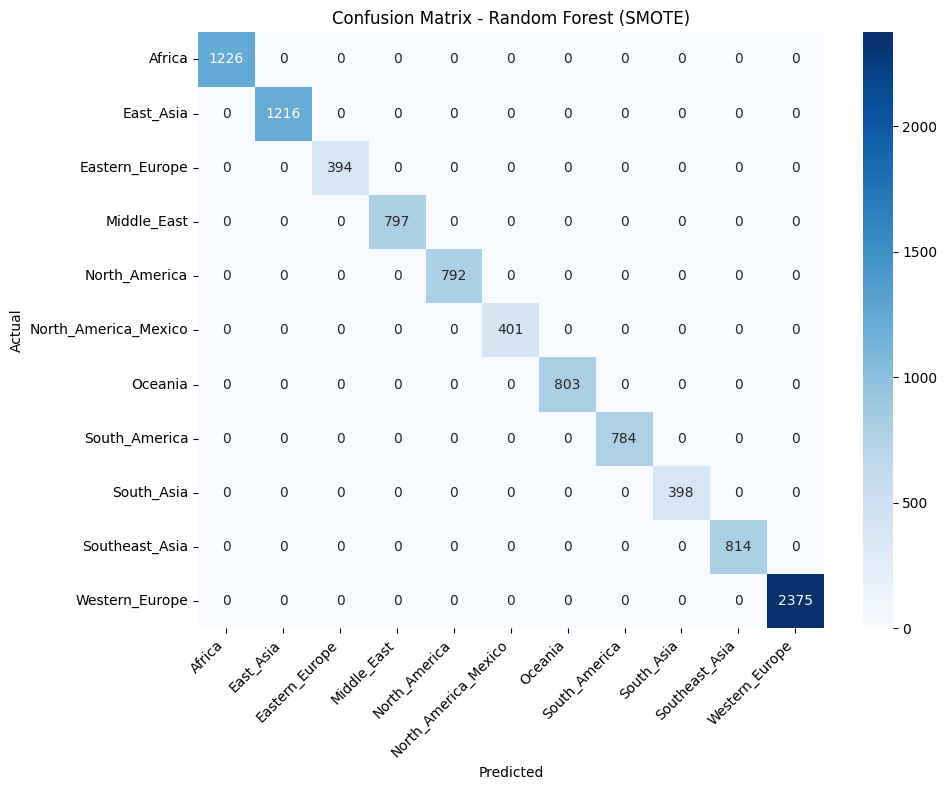

In [13]:
y_pred = rf_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Evaluation Metrics:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# --- Confusion Matrix ---
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Random Forest (SMOTE)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# LogisticRegression

In [14]:
log_reg_model = LogisticRegression(
    max_iter=1000,
    multi_class='multinomial',
    solver='lbfgs',
    random_state=42
)

log_reg_model.fit(X_train_res, y_train_res)

'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'multinomial'


Evaluation Metrics:
Accuracy:  0.7952
Precision: 0.8244
Recall:    0.7952
F1 Score:  0.7903

Classification Report:
                      precision    recall  f1-score   support

              Africa       0.72      0.69      0.70      1226
           East_Asia       0.91      0.96      0.93      1216
      Eastern_Europe       1.00      1.00      1.00       394
         Middle_East       0.91      0.53      0.67       797
       North_America       1.00      1.00      1.00       792
North_America_Mexico       1.00      1.00      1.00       401
             Oceania       0.50      1.00      0.67       803
       South_America       1.00      1.00      1.00       784
          South_Asia       0.54      1.00      0.70       398
      Southeast_Asia       1.00      1.00      1.00       814
      Western_Europe       0.73      0.48      0.58      2375

            accuracy                           0.80     10000
           macro avg       0.85      0.88      0.84     10000
        weight

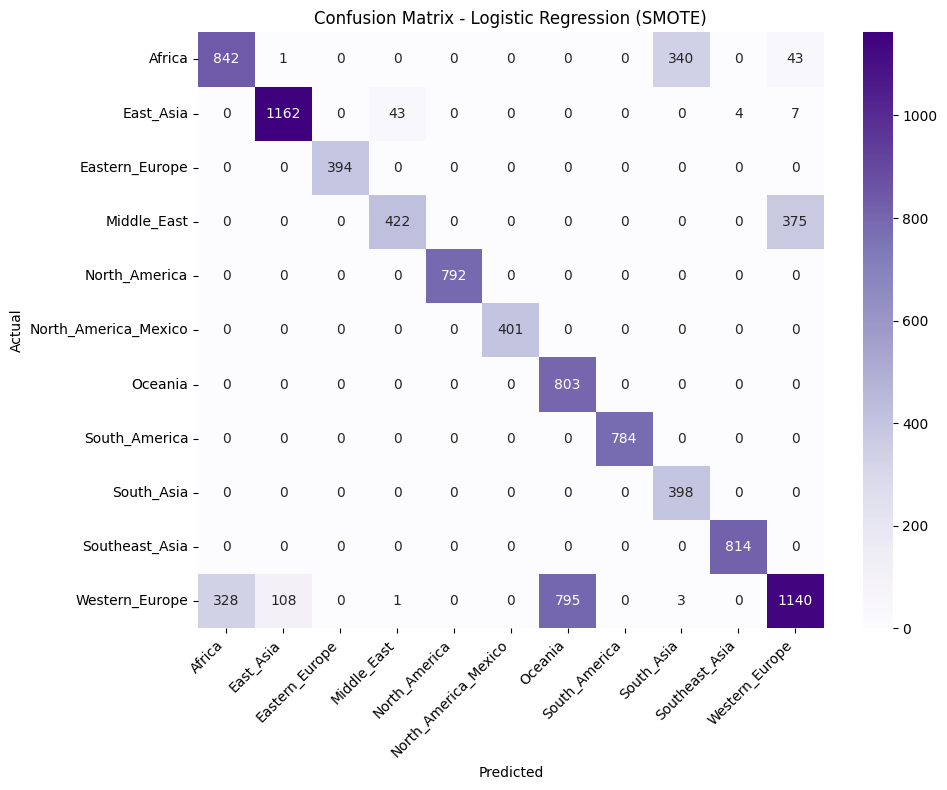

In [15]:
y_pred = log_reg_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Evaluation Metrics:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# --- Confusion Matrix ---
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Purples',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Logistic Regression (SMOTE)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# Neural Network

In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

X_train, X_test_scaled, y_train, y_test_scaled = train_test_split(
    X_scaled, y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [17]:
num_classes = len(le.classes_)

ffnn_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # output neurons = num of classes
])

ffnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

ffnn_model.summary()

2025-10-24 15:31:57.353327: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 11)             │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 507 (1.98 KB)

 Trainable params: 507 (1.98 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history = ffnn_model.fit(
    X_train, y_train,
    validation_data=(X_test_scaled, y_test_scaled),
    epochs=20,
    batch_size=64,
    verbose=1
)


Epoch 1/20
1633/1633 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5099 - loss: 1.4659 - val_accuracy: 0.9999 - val_loss: 0.0750
Epoch 2/20
1633/1633 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9998 - loss: 0.0371 - val_accuracy: 1.0000 - val_loss: 0.0082
Epoch 3/20
1633/1633 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 1.0000 - loss: 0.0045 - val_accuracy: 1.0000 - val_loss: 0.0018
Epoch 4/20
1633/1633 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 5.4186e-04
Epoch 5/20
1633/1633 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 1.0000 - loss: 3.4975e-04 - val_accuracy: 1.0000 - val_loss: 1.9305e-04
Epoch 6/20
1633/1633 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 1.0000 - loss: 1.2235e-04 - val_accuracy: 1.0000 - val_loss: 6.9602e-05
Epoch 7/20
1633/1633 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 1.0000 - loss: 4.4922e-05 - val_accuracy: 1.0000 - val_loss: 2.5039e-05
Epoch 8/20
1633/1633 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accura

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

 Evaluation Metrics:
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1 Score:  1.0000

Classification Report:
                      precision    recall  f1-score   support

              Africa       1.00      1.00      1.00      1226
           East_Asia       1.00      1.00      1.00      1216
      Eastern_Europe       1.00      1.00      1.00       394
         Middle_East       1.00      1.00      1.00       797
       North_America       1.00      1.00      1.00       792
North_America_Mexico       1.00      1.00      1.00       401
             Oceania       1.00      1.00      1.00       803
       South_America       1.00      1.00      1.00       784
          South_Asia       1.00      1.00      1.00       398
      Southeast_Asia       1.00      1.00      1.00       814
      Western_Europe       1.00      1.00      1.00      2375

            accuracy                           1.00     10000
           macro avg       1.00  

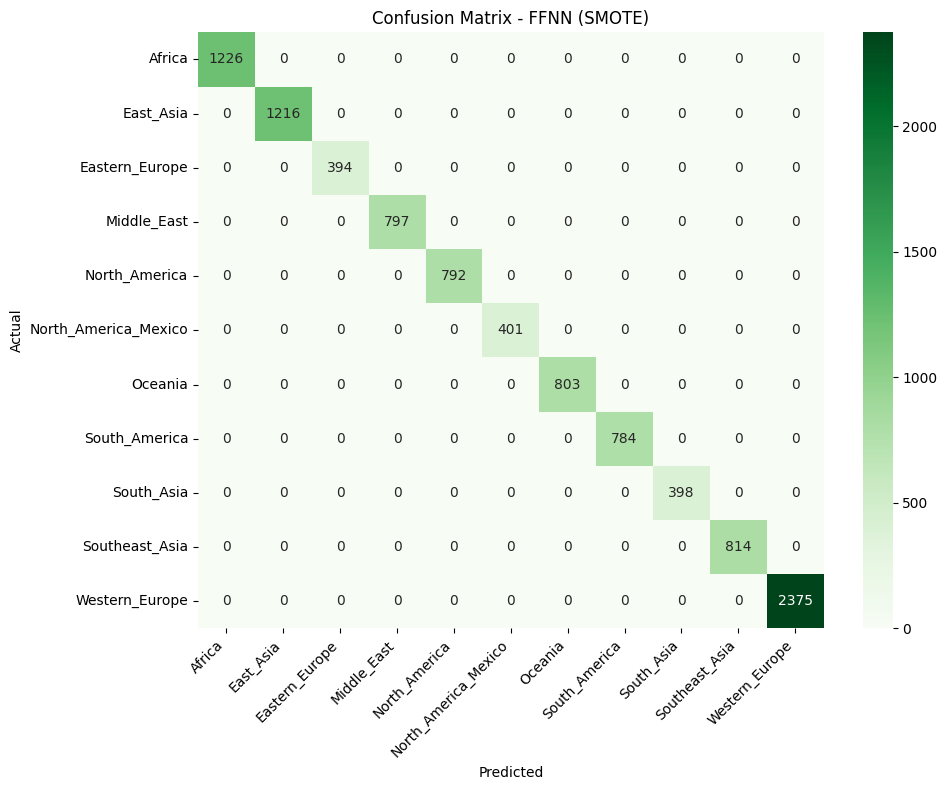

In [19]:
y_pred_probs = ffnn_model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)

acc = accuracy_score(y_test_scaled, y_pred)
prec = precision_score(y_test_scaled, y_pred, average='weighted')
rec = recall_score(y_test_scaled, y_pred, average='weighted')
f1 = f1_score(y_test_scaled, y_pred, average='weighted')

print("\n Evaluation Metrics:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_scaled, y_pred, target_names=le.classes_))

# --- Confusion Matrix ---
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test_scaled, y_pred), annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - FFNN (SMOTE)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


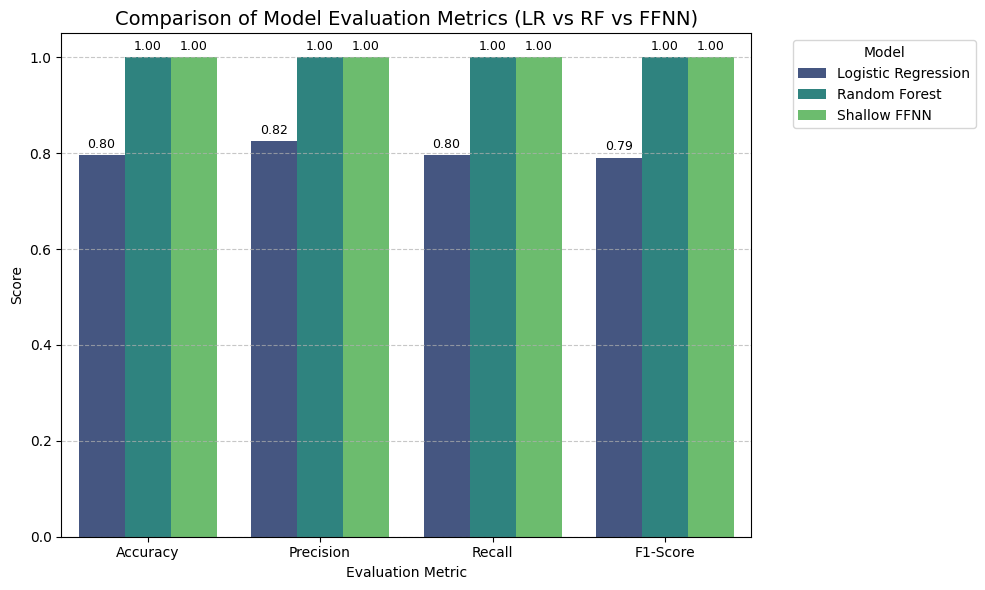


 Model Performance Summary:



,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.7952,0.8244,0.7952,0.7903
1,Random Forest,1.0000,1.0000,1.0000,1.0000
2,Shallow FFNN,1.0000,1.0000,1.0000,1.0000


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


y_pred_lr = log_reg_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)


y_pred_probs = ffnn_model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)

if len(y_test_scaled.shape) > 1:
    y_true = np.argmax(y_test_scaled, axis=1)
else:
    y_true = y_test_scaled



def get_metrics(y_true, y_pred, model_name):
    """Return a dictionary of evaluation metrics for a given model."""
    return {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='weighted'),
        'Recall': recall_score(y_true, y_pred, average='weighted'),
        'F1-Score': f1_score(y_true, y_pred, average='weighted')
    }

results = []
results.append(get_metrics(y_true, y_pred_lr, 'Logistic Regression'))
results.append(get_metrics(y_true, y_pred_rf, 'Random Forest'))
results.append(get_metrics(y_true, y_pred, 'Shallow FFNN'))


comparison_df = pd.DataFrame(results)

comparison_melted = comparison_df.melt(
    id_vars='Model', 
    var_name='Metric', 
    value_name='Score'
)



plt.figure(figsize=(10, 6))
sns.barplot(
    data=comparison_melted, 
    x='Metric', 
    y='Score', 
    hue='Model', 
    palette='viridis'
)

# Add score labels on top of bars
for bar in plt.gca().patches:
    plt.gca().text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.01,
        f"{bar.get_height():.2f}",
        ha='center',
        va='bottom',
        fontsize=9
    )

# Final formatting
plt.title('Comparison of Model Evaluation Metrics (LR vs RF vs FFNN)', fontsize=14)
plt.ylim(0, 1.05)
plt.ylabel('Score')
plt.xlabel('Evaluation Metric')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



print("\n Model Performance Summary:\n")
display(comparison_df.round(4))


# Some Features

In [21]:
score_features = [
    'score_overall',
    'score_cleanliness',
    'score_comfort',
    'score_facilities',
    'score_location',
    'score_staff',
    'score_value_for_money'
]

user_features = ['age_group', 'traveller_type', 'user_gender']


X_All = df[score_features + user_features]
all_features = score_features + user_features


X = df[all_features]
y = df['country_group']


X_encoded = X.copy()
X_encoded['age_group'] = X_encoded['age_group'].astype('category').cat.codes
X_encoded['traveller_type'] = X_encoded['traveller_type'].astype('category').cat.codes
X_encoded['user_gender'] = X_encoded['user_gender'].astype('category').cat.codes


le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)

In [23]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:")
print(pd.Series(y_train).value_counts().sort_index())
print("\nAfter SMOTE:")
print(pd.Series(y_train_res).value_counts().sort_index())

Before SMOTE:
0     4906
1     4866
2     1576
3     3186
4     3170
5     1603
6     3211
7     3134
8     1591
9     3256
10    9501
Name: count, dtype: int64

After SMOTE:
0     9501
1     9501
2     9501
3     9501
4     9501
5     9501
6     9501
7     9501
8     9501
9     9501
10    9501
Name: count, dtype: int64


# Random Forest

In [24]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    random_state=42
)

rf_model.fit(X_train_res, y_train_res)

,n_estimators,200
,criterion,'gini'
,max_depth,10
,min_samples_split,5
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Evaluation Metrics:
Accuracy:  0.3208
Precision: 0.3834
Recall:    0.3208
F1 Score:  0.3323

Classification Report:
                      precision    recall  f1-score   support

              Africa       0.54      0.23      0.33      1226
           East_Asia       0.46      0.36      0.40      1216
      Eastern_Europe       0.11      0.37      0.17       394
         Middle_East       0.43      0.25      0.32       797
       North_America       0.37      0.30      0.33       792
North_America_Mexico       0.20      0.50      0.28       401
             Oceania       0.28      0.14      0.19       803
       South_America       0.25      0.19      0.22       784
          South_Asia       0.11      0.20      0.14       398
      Southeast_Asia       0.25      0.36      0.29       814
      Western_Europe       0.50      0.45      0.47      2375

            accuracy                           0.32     10000
           macro avg       0.32      0.31      0.29     10000
        weight

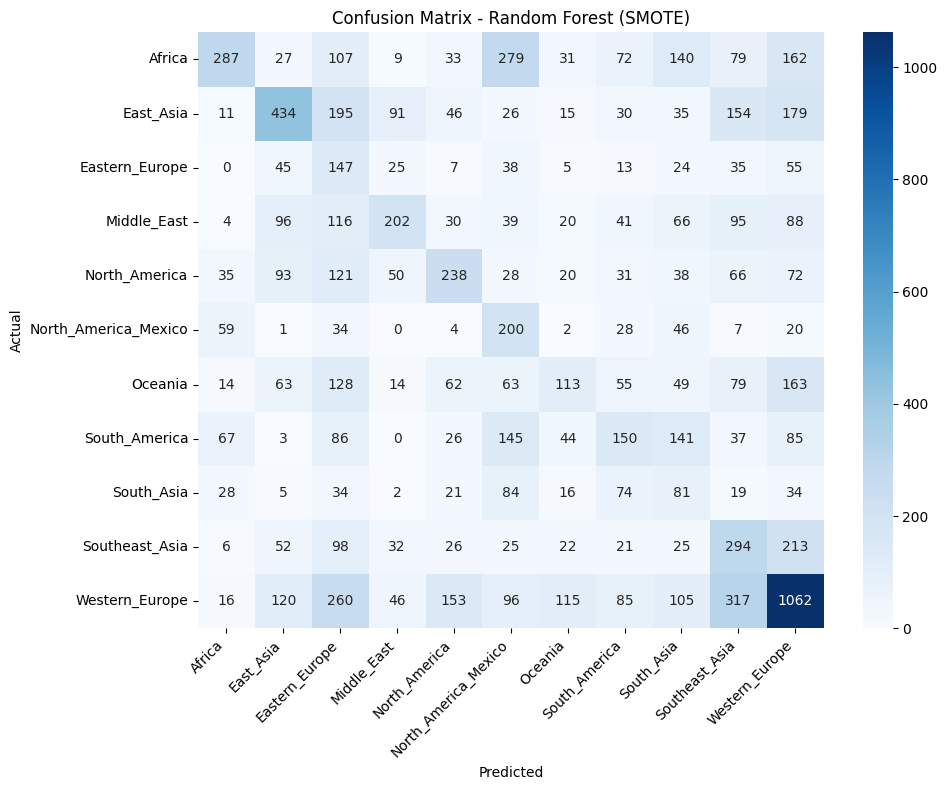

In [25]:
y_pred = rf_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Evaluation Metrics:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# --- Confusion Matrix ---
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Random Forest (SMOTE)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Logistic Regression

In [26]:
log_reg_model = LogisticRegression(
    max_iter=1000,
    multi_class='multinomial',
    solver='lbfgs',
    random_state=42
)

log_reg_model.fit(X_train_res, y_train_res)

'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'multinomial'


Evaluation Metrics:
Accuracy:  0.2249
Precision: 0.2615
Recall:    0.2249
F1 Score:  0.2243

Classification Report:
                      precision    recall  f1-score   support

              Africa       0.25      0.15      0.19      1226
           East_Asia       0.31      0.30      0.31      1216
      Eastern_Europe       0.09      0.24      0.13       394
         Middle_East       0.24      0.13      0.17       797
       North_America       0.17      0.20      0.18       792
North_America_Mexico       0.17      0.49      0.26       401
             Oceania       0.11      0.08      0.09       803
       South_America       0.23      0.31      0.26       784
          South_Asia       0.10      0.05      0.07       398
      Southeast_Asia       0.20      0.37      0.26       814
      Western_Europe       0.44      0.22      0.29      2375

            accuracy                           0.22     10000
           macro avg       0.21      0.23      0.20     10000
        weight

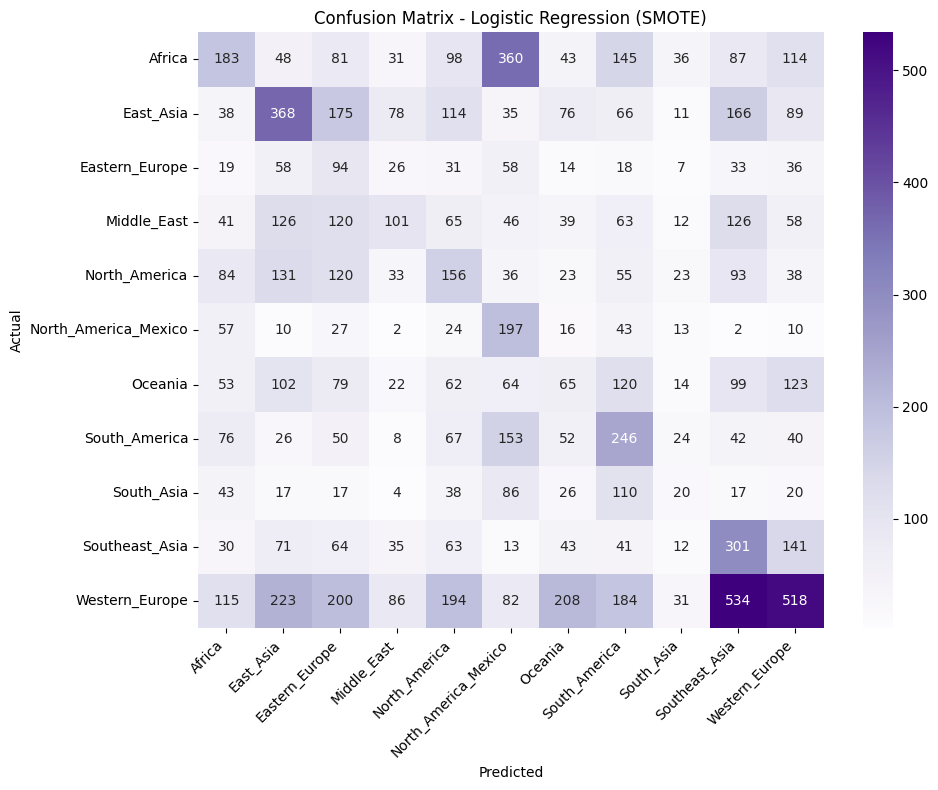

In [27]:
y_pred = log_reg_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Evaluation Metrics:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# --- Confusion Matrix ---
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Purples',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Logistic Regression (SMOTE)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# Neural Network

In [28]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

X_train, X_test_scaled, y_train, y_test_scaled = train_test_split(
    X_scaled, y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [29]:
num_classes = len(le.classes_)

ffnn_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # output neurons = num of classes
])

ffnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

ffnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 16)             │           176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 11)             │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411 (1.61 KB)

 Trainable params: 411 (1.61 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
history = ffnn_model.fit(
    X_train, y_train,
    validation_data=(X_test_scaled, y_test_scaled),
    epochs=20,
    batch_size=64,
    verbose=1
)


Epoch 1/20
1633/1633 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.1915 - loss: 2.2256 - val_accuracy: 0.2314 - val_loss: 2.1031
Epoch 2/20
1633/1633 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.2612 - loss: 2.0281 - val_accuracy: 0.2449 - val_loss: 2.0577
Epoch 3/20
1633/1633 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.2759 - loss: 1.9821 - val_accuracy: 0.2552 - val_loss: 2.0236
Epoch 4/20
1633/1633 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.2833 - loss: 1.9582 - val_accuracy: 0.2631 - val_loss: 2.0081
Epoch 5/20
1633/1633 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.2855 - loss: 1.9492 - val_accuracy: 0.2567 - val_loss: 2.0026
Epoch 6/20
1633/1633 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.2906 - loss: 1.9369 - val_accuracy: 0.2624 - val_loss: 2.0004
Epoch 7/20
1633/1633 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.2924 - loss: 1.9261 - val_accuracy: 0.2682 - val_loss: 1.9797
Epoch 8/20
1633/1633 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.2984 - loss: 1.9190 - 

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

 Evaluation Metrics:
Accuracy:  0.2800
Precision: 0.3544
Recall:    0.2800
F1 Score:  0.2920

Classification Report:
                      precision    recall  f1-score   support

              Africa       0.45      0.20      0.27      1226
           East_Asia       0.43      0.34      0.38      1216
      Eastern_Europe       0.10      0.32      0.16       394
         Middle_East       0.28      0.22      0.25       797
       North_America       0.32      0.35      0.33       792
North_America_Mexico       0.19      0.48      0.27       401
             Oceania       0.17      0.16      0.16       803
       South_America       0.25      0.29      0.27       784
          South_Asia       0.09      0.15      0.11       398
      Southeast_Asia       0.24      0.38      0.30       814
      Western_Europe       0.55      0.27      0.36      2375

            accuracy                           0.28     10000
           macro avg       0.28  

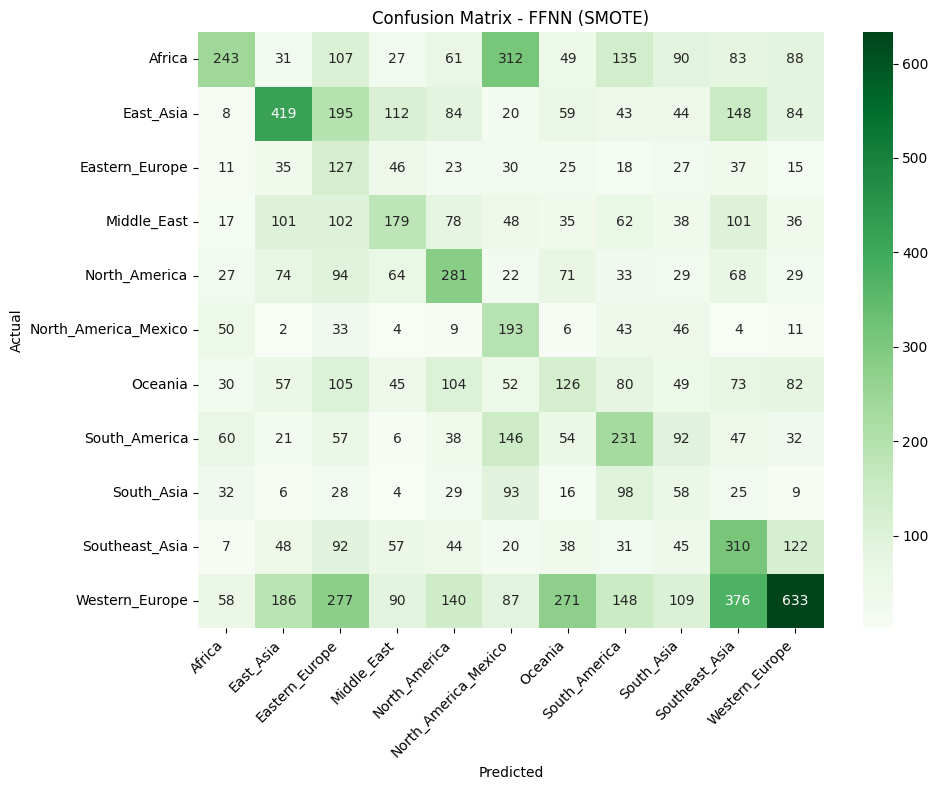

In [31]:
y_pred_probs = ffnn_model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)

acc = accuracy_score(y_test_scaled, y_pred)
prec = precision_score(y_test_scaled, y_pred, average='weighted')
rec = recall_score(y_test_scaled, y_pred, average='weighted')
f1 = f1_score(y_test_scaled, y_pred, average='weighted')

print("\n Evaluation Metrics:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_scaled, y_pred, target_names=le.classes_))

# --- Confusion Matrix ---
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test_scaled, y_pred), annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - FFNN (SMOTE)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


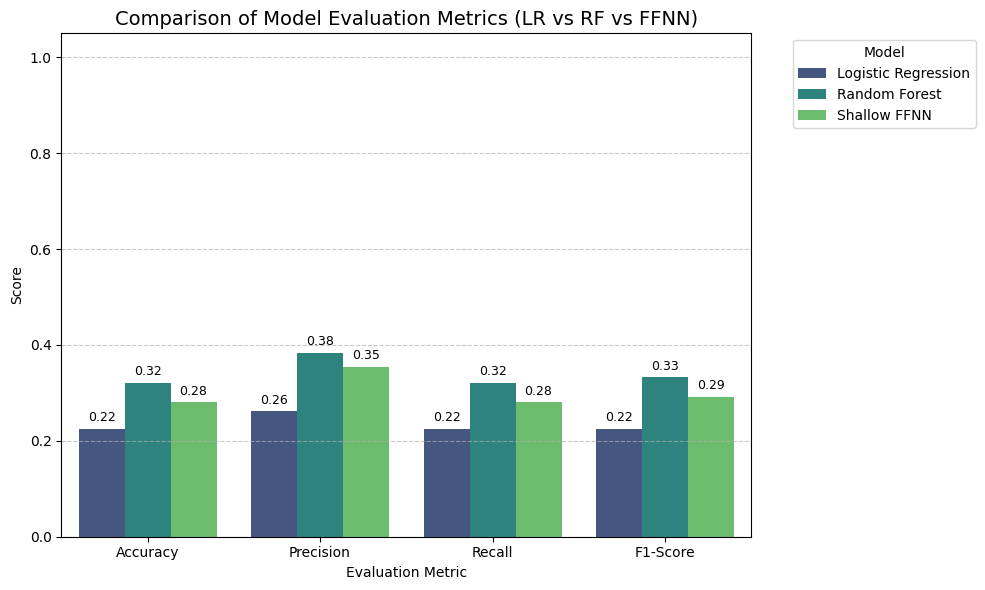


 Model Performance Summary:



,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.2249,0.2615,0.2249,0.2243
1,Random Forest,0.3208,0.3834,0.3208,0.3323
2,Shallow FFNN,0.2800,0.3544,0.2800,0.2920


In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


y_pred_lr = log_reg_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)


y_pred_probs = ffnn_model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)

if len(y_test_scaled.shape) > 1:
    y_true = np.argmax(y_test_scaled, axis=1)
else:
    y_true = y_test_scaled



def get_metrics(y_true, y_pred, model_name):
    """Return a dictionary of evaluation metrics for a given model."""
    return {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='weighted'),
        'Recall': recall_score(y_true, y_pred, average='weighted'),
        'F1-Score': f1_score(y_true, y_pred, average='weighted')
    }

results = []
results.append(get_metrics(y_true, y_pred_lr, 'Logistic Regression'))
results.append(get_metrics(y_true, y_pred_rf, 'Random Forest'))
results.append(get_metrics(y_true, y_pred, 'Shallow FFNN'))


comparison_df = pd.DataFrame(results)

comparison_melted = comparison_df.melt(
    id_vars='Model', 
    var_name='Metric', 
    value_name='Score'
)



plt.figure(figsize=(10, 6))
sns.barplot(
    data=comparison_melted, 
    x='Metric', 
    y='Score', 
    hue='Model', 
    palette='viridis'
)

# Add score labels on top of bars
for bar in plt.gca().patches:
    plt.gca().text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.01,
        f"{bar.get_height():.2f}",
        ha='center',
        va='bottom',
        fontsize=9
    )

# Final formatting
plt.title('Comparison of Model Evaluation Metrics (LR vs RF vs FFNN)', fontsize=14)
plt.ylim(0, 1.05)
plt.ylabel('Score')
plt.xlabel('Evaluation Metric')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



print("\n Model Performance Summary:\n")
display(comparison_df.round(4))


# Adding hotel Location

In [33]:
score_features = [
    'score_overall', 
    'score_cleanliness', 
    'score_comfort', 
    'score_facilities', 
    'score_location', 
    'score_staff', 
    'score_value_for_money', 
    'location_base', 
]

user_features = ['age_group', 'traveller_type', 'user_gender']
all_features = score_features + user_features

X = df[all_features]
y = df['country_group']

X_encoded = X.copy()
X_encoded['age_group'] = X_encoded['age_group'].astype('category').cat.codes
X_encoded['traveller_type'] = X_encoded['traveller_type'].astype('category').cat.codes
X_encoded['user_gender'] = X_encoded['user_gender'].astype('category').cat.codes

le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)

In [35]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
# Check new class distribution
from collections import Counter
print("Class distribution after oversampling:", Counter(y_train_res))

print("Before SMOTE:")
print(pd.Series(y_train).value_counts().sort_index())
print("\nAfter SMOTE:")
print(pd.Series(y_train_res).value_counts().sort_index())

Class distribution after oversampling: Counter({0: 9501, 5: 9501, 10: 9501, 3: 9501, 4: 9501, 7: 9501, 9: 9501, 1: 9501, 6: 9501, 2: 9501, 8: 9501})
Before SMOTE:
0     4906
1     4866
2     1576
3     3186
4     3170
5     1603
6     3211
7     3134
8     1591
9     3256
10    9501
Name: count, dtype: int64

After SMOTE:
0     9501
1     9501
2     9501
3     9501
4     9501
5     9501
6     9501
7     9501
8     9501
9     9501
10    9501
Name: count, dtype: int64


# Random Forest

In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    random_state=42
)

rf_model.fit(X_train_res, y_train_res)

📊 Evaluation Metrics:
Accuracy:  0.7171
Precision: 0.7532
Recall:    0.7171
F1 Score:  0.7182

Classification Report:
                      precision    recall  f1-score   support

              Africa       0.86      0.74      0.80      1226
           East_Asia       0.84      0.59      0.69      1216
      Eastern_Europe       0.38      0.79      0.51       394
         Middle_East       0.75      0.93      0.83       797
       North_America       0.80      0.86      0.83       792
North_America_Mexico       0.50      0.81      0.61       401
             Oceania       0.70      0.54      0.61       803
       South_America       0.62      0.38      0.47       784
          South_Asia       0.98      1.00      0.99       398
      Southeast_Asia       0.55      0.91      0.69       814
      Western_Europe       0.83      0.68      0.75      2375

            accuracy                           0.72     10000
           macro avg       0.71      0.75      0.71     10000
        weig

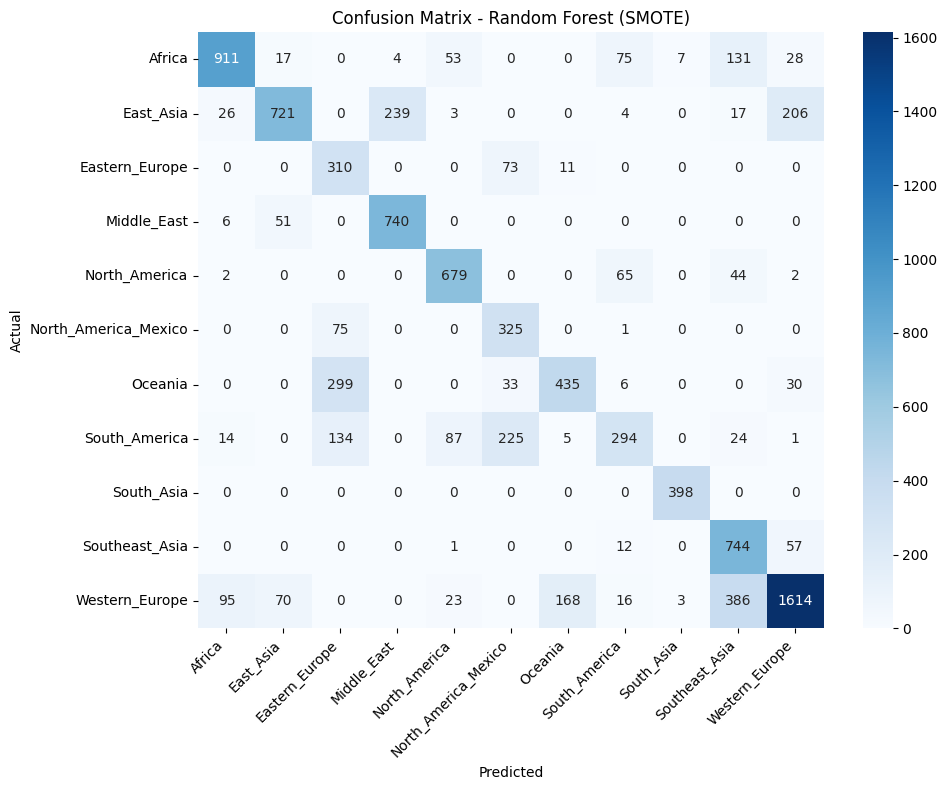

In [37]:
y_pred = rf_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Evaluation Metrics:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# --- Confusion Matrix ---
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Random Forest (SMOTE)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

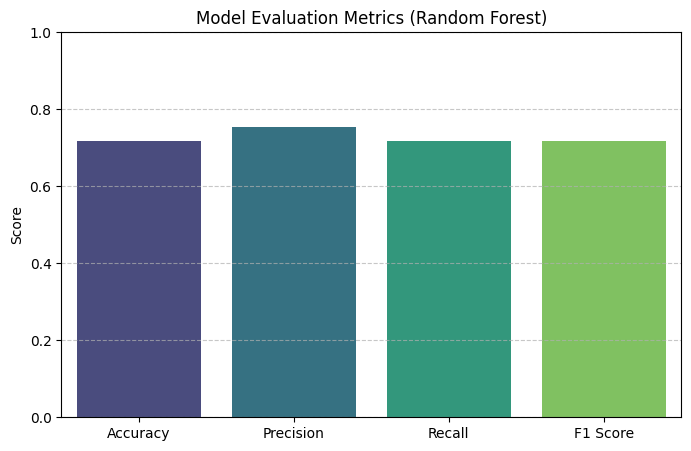

In [39]:
# --- Store metrics in a dictionary ---
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, average='weighted'),
    'Recall': recall_score(y_test, y_pred, average='weighted'),
    'F1 Score': f1_score(y_test, y_pred, average='weighted')
}


import pandas as pd
metrics_df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Score'])

plt.figure(figsize=(8, 5))
sns.barplot(data=metrics_df, x='Metric', y='Score', palette='viridis')
plt.ylim(0, 1)
plt.title('Model Evaluation Metrics (Random Forest)')
plt.ylabel('Score')
plt.xlabel('')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


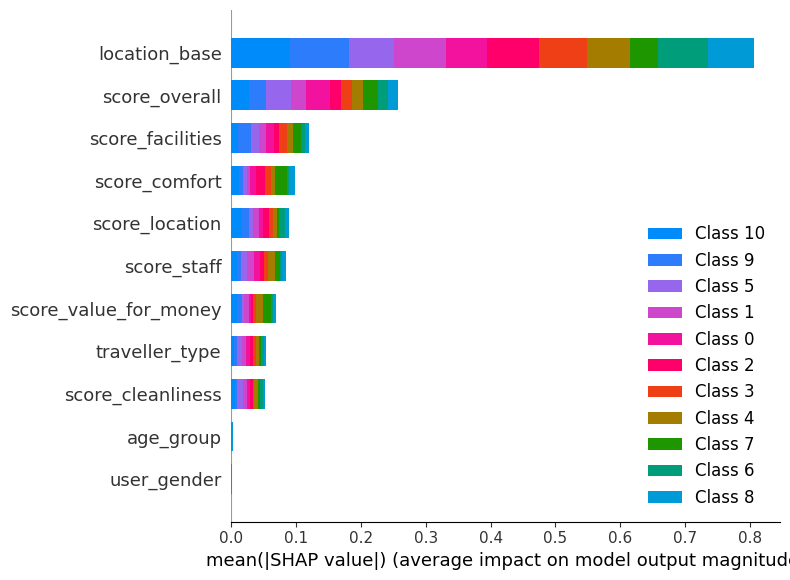

In [40]:
# --- SHAP Global Explanation for Random Forest --- 
explainer = shap.TreeExplainer(rf_model) 
shap_values = explainer.shap_values(X_test) 

# Global SHAP summary plot
shap.summary_plot(shap_values, X_test, feature_names=X.columns)


 Global SHAP summary for Africa:


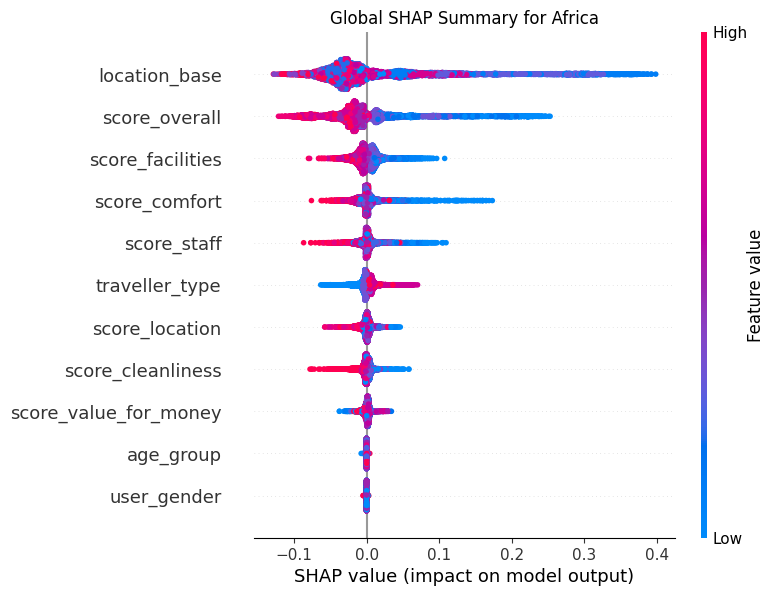


 Global SHAP summary for East_Asia:


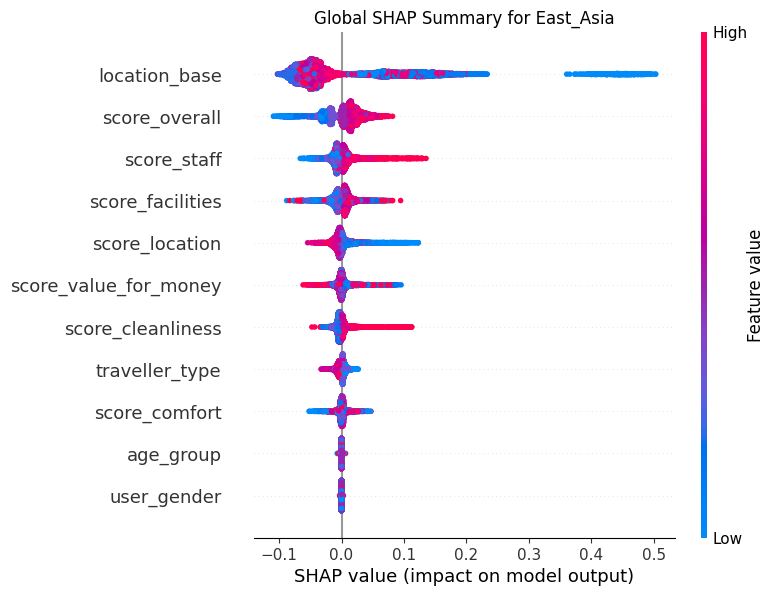


 Global SHAP summary for Eastern_Europe:


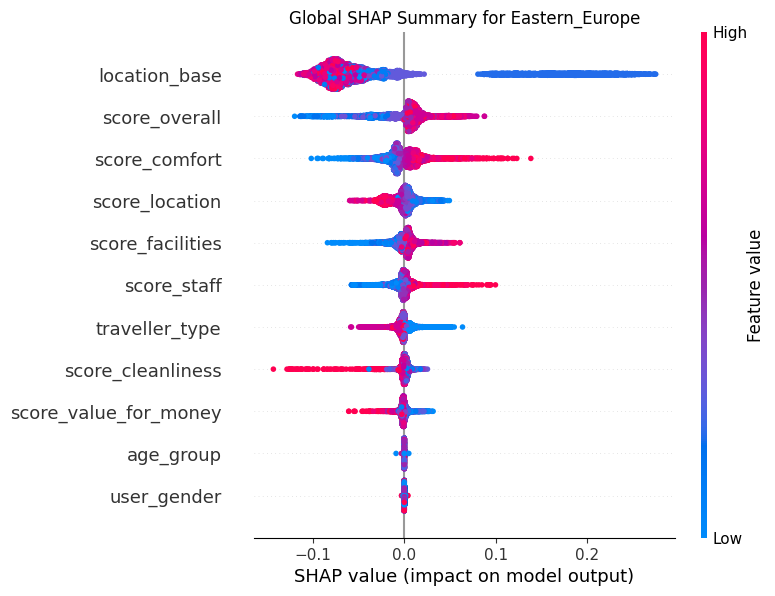


 Global SHAP summary for Middle_East:


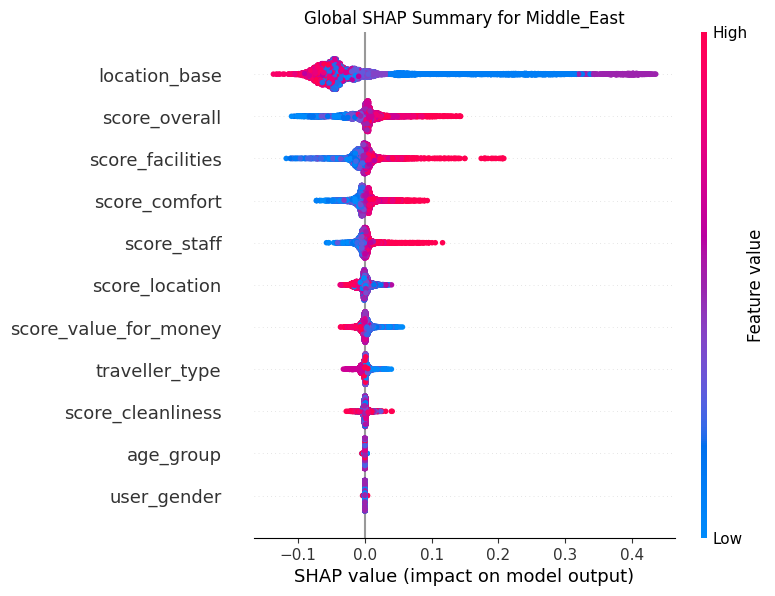


 Global SHAP summary for North_America:


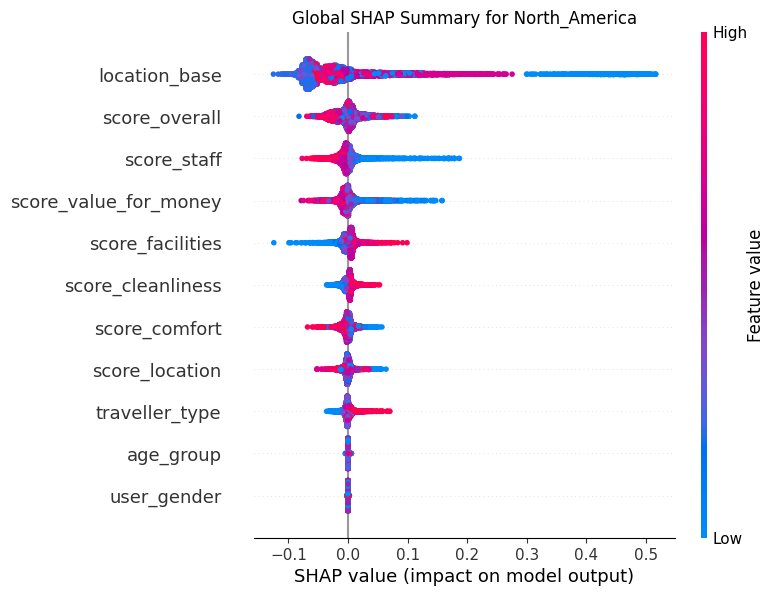


 Global SHAP summary for North_America_Mexico:


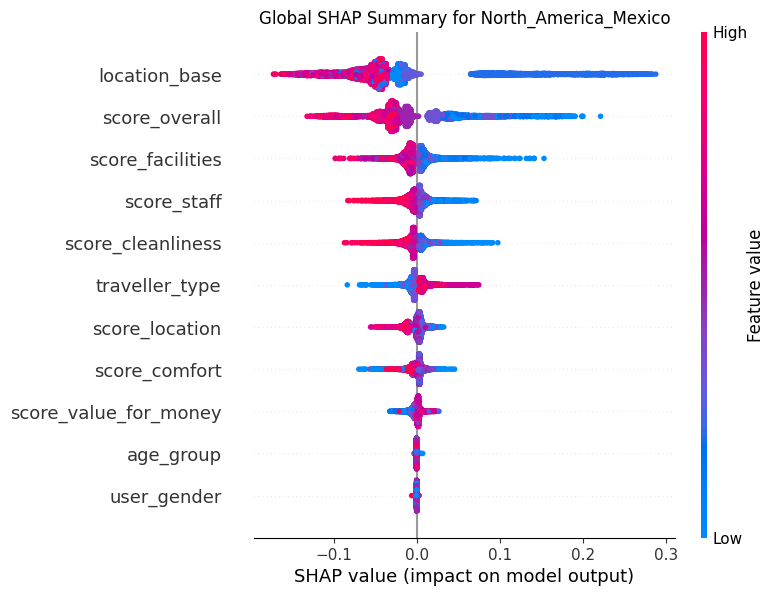


 Global SHAP summary for Oceania:


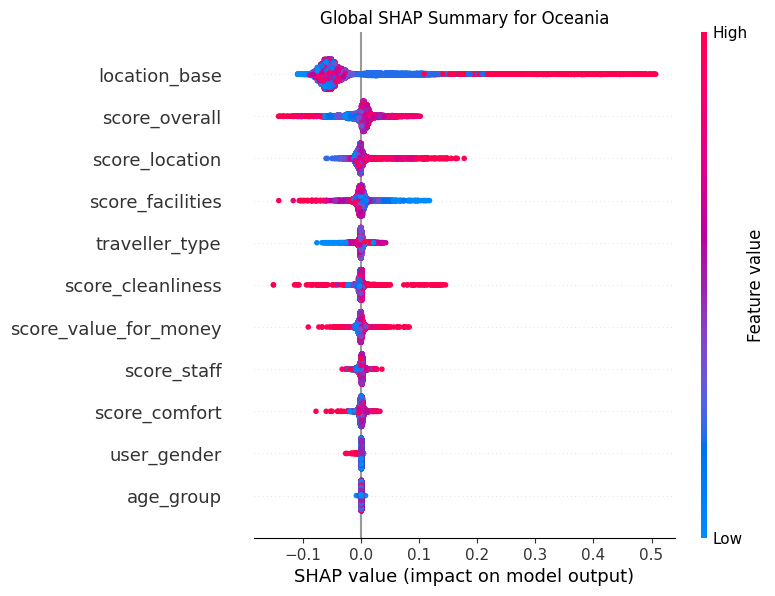


 Global SHAP summary for South_America:


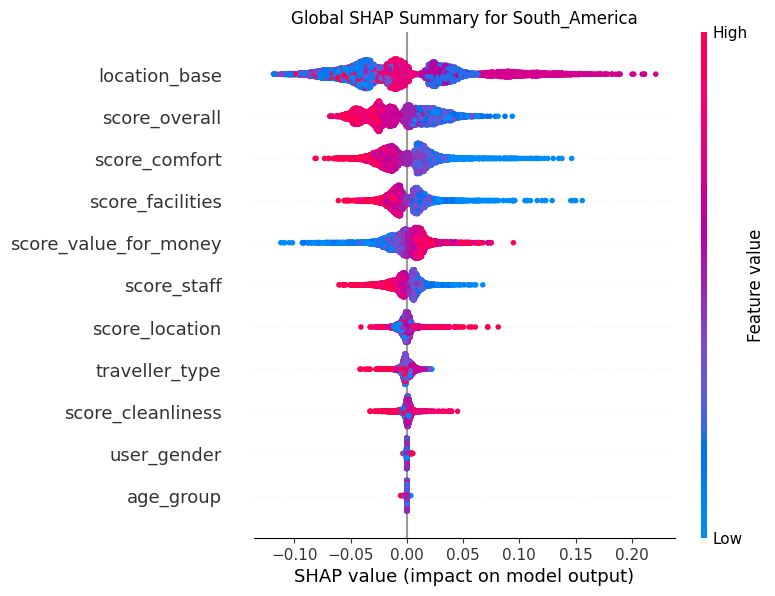


 Global SHAP summary for South_Asia:


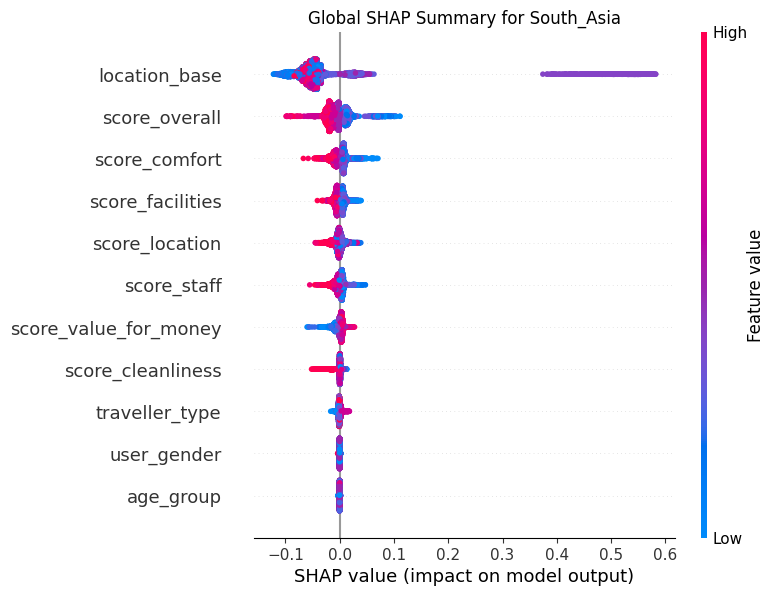


 Global SHAP summary for Southeast_Asia:


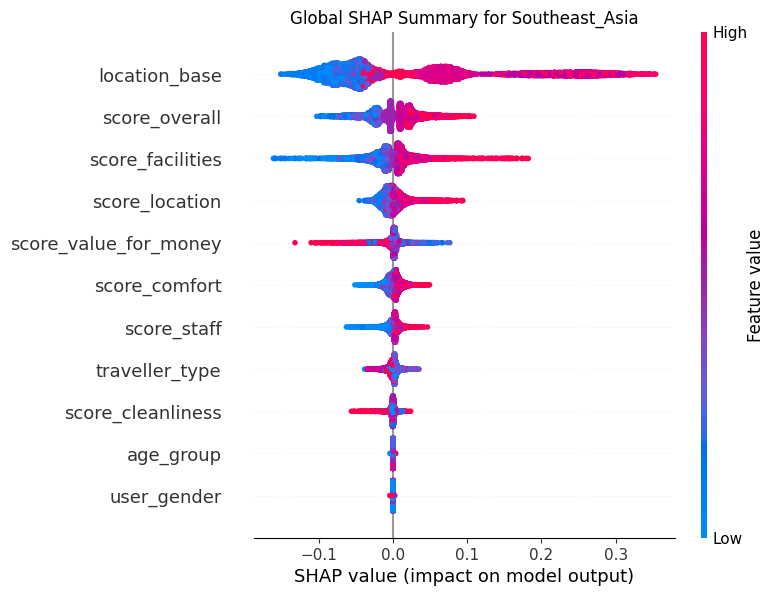


 Global SHAP summary for Western_Europe:


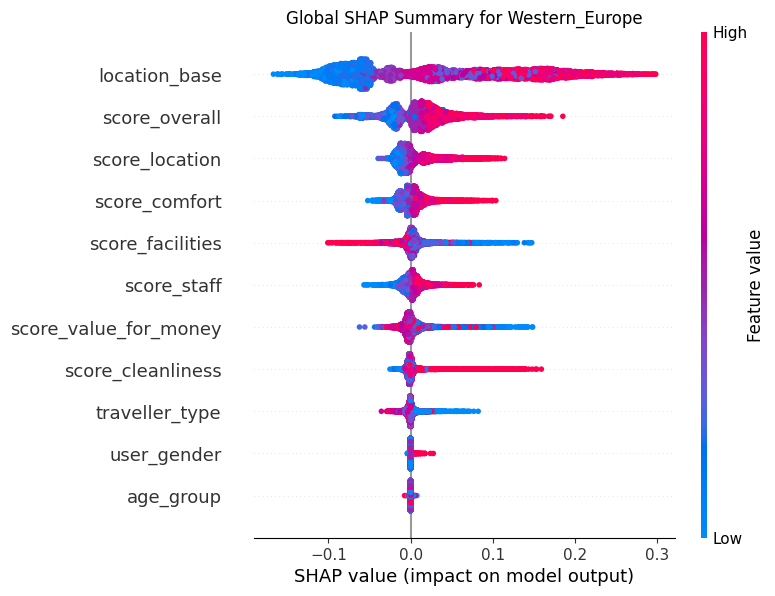

In [47]:
label_mapping = {
    'Africa': 0,
    'East_Asia': 1,
    'Eastern_Europe': 2,
    'Middle_East': 3,
    'North_America': 4,
    'North_America_Mexico': 5,
    'Oceania': 6,
    'South_America': 7,
    'South_Asia': 8,
    'Southeast_Asia': 9,
    'Western_Europe': 10
}


# Invert mapping: number → country name
class_names = {v: k for k, v in label_mapping.items()}

# --- Compute SHAP values ---
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# --- Global SHAP summary plot for multi-class ---
for i, class_name in class_names.items():
    print(f"\n Global SHAP summary for {class_name}:")
    shap.summary_plot(shap_values[i], X_test, feature_names=X_test.columns, show=False)
    plt.title(f"Global SHAP Summary for {class_name}")
    plt.show()


In [42]:
# Choose an example to explain
i = 0  # you can change the index

# Force plot for one prediction
shap.initjs()
shap.force_plot(
    explainer.expected_value[0],  # baseline prediction
    shap_values[0][i],            # SHAP values for this instance
    X_test.iloc[i],               # feature values
    feature_names=X.columns
)


In [46]:
import lime
import lime.lime_tabular


feature_names = X_train.columns

explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=feature_names,
    class_names=np.unique(y).astype(str),  # ensure proper labels
    discretize_continuous=True,
    mode='classification'
)


i = 5  
exp = explainer_lime.explain_instance(
    X_test.values[i],
    rf_model.predict_proba,   
    num_features=len(feature_names)
)


exp.show_in_notebook()


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
